<h1 align="center"> IST 5520 Milestone 2: Data Analysis I <h1>
<h3 align="center"> AirBnB Dataset <h3>

#### Student: Ronald Adomako
#### Student: Idris Dobbs
#### Student: Narendra Chigili
#### Student: Nikhil Srirama Sai

# Cleanse and visualize data

## Introduction

AirBnB is a PaaS for the short term rental market. Users use the platform to list residences for short term rentals. We noticed that for big cities, such as New York City, there are many host and some may want to use AirBnB for lucrative means. Given location and characteristics of a property, a new host would want to know whether he or she is charging the optimal amount to rent the space to lodgers.

We noticed that from the New York City dataset for AirBnB, the categorical variable for location  was too coarse. The descriptor says the location is categorized into five boroughs. For a big city such as New York City, there are a lot of insights missing from a business perspective because neighborhoods vary drastically in property amenities even within a single borough. Moreso, the geo-coordinates are too fine for business purposes. To handle this we implement a zip code converter to categorize properties based on their location - Feature Selection.

- What are the largest determinants / predictors of AirBnB rental prices?
- How can we optimize rental revenue based on rental location and other characteristics?
- What price should be charged based on rental location/ characteristics?

We are opperating under the assumption that NYC AirBnB prices has reached a *steady-state*: i.e. the market has been active for long enough in NYC and there are enough data points (observations) in NYC that the **mean** is meaningful.

We want to know whether a host is charging an optimal price. To do this we group the observations by neigborhood and then take the average price. Hosts who charge at or above this price are considered optimal in their respective neighborhood while hosts who charge below the average price for their neighborhood are sub-optimal. Consider the case where all hosts charge the same price within a neighborhood, then the mean is the mode is the median- uniform data, no variance. All the hosts in this neighborhood would be optimal.

Consider the case where one of those hosts charge below what would have been the average, then only that host is sub-optimal while the rest are optimal. Conversely, if one host charge above the rest while everyone else charges the same, then that one host would be optimal while the rest are suboptimal.

Along with the *steady-state* assumption, by grouping the data by neighborhoods we assume that on average homes and amenities are similar by neighborhood. The geo-coordinates are too fine a scale and the boroughs are too coarse a scale. A meso-scale would be by zipcode, which we would expect to have higher precision of similarities between host, or by neighborhood. For a dataset with 39881 observations, transforming geo-coordinates prove to be computationally expensive (22 hours on standard household computer). We chose the next best meso-scale: what AirBnB features as "neighbourhood".

From a business perspective, we want to know what percent of hosts per neighborhood are charging an optimal price, and aggregating this data the percent hosts charge an optimal price in NYC overall. We see that using the neighborhood grouping allows us to compare on a common scale for all hosts. We don't have hosts income, so we wouldn't be able to measure profit. Likewise, revenue wouldn't be a fair scale because hosts with more units will outperform host with smaller units just by volume. A nieghborhood comparison allows a better metric to assess price per room, where we expect reasonably small variance per neighborhood. Furthermore, comparing by percentage is normalizes our comparison in general.

## Data Source and Collection

#### We chose the AirBnB dataset for New York City (NYC). We want to build a model that indicates whether hosts are charging an optimum amount for their rental.

http://insideairbnb.com/new-york-city/

[data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing)

http://insideairbnb.com/get-the-data

http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from scipy import stats as st
import statsmodels as sts
import statsmodels.api as sm

%matplotlib inline

In [2]:
data = pd.read_csv('/Users/palaparthisainikhil/Downloads/IST5520GrpProj-milestone3/Grp3Project_InitialData/data_dictionary.csv')
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
d1=pd.read_csv("Brooklyn_zipcodes.csv")
d2=pd.read_csv("Manhattan_zipcodes.csv")
df2 = pd.concat([d1,d2])

#df2 = pd.read_csv(csv_URL)

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31692 entries, 0 to 16846
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      31692 non-null  int64  
 1   id                              31692 non-null  float64
 2   name                            31681 non-null  object 
 3   host_id                         31692 non-null  int64  
 4   host_name                       31642 non-null  object 
 5   neighbourhood_group             31692 non-null  object 
 6   neighbourhood                   31692 non-null  object 
 7   latitude                        31692 non-null  float64
 8   longitude                       31692 non-null  float64
 9   room_type                       31692 non-null  object 
 10  price                           31692 non-null  int64  
 11  minimum_nights                  31692 non-null  int64  
 12  number_of_reviews               

In [4]:
data_dict = pd.DataFrame(df2.columns, columns=['Features'])
data_dict['Description']=None

### Dimensional Analysis
- What are the largest determinants / predictors of AirBnB rental prices?

The data dictionary for New York City AirBnB dataset consists of 75 columns (variables or features) and 39881 observations. Based on our research question and several [Kaggle challenges](https://www.kaggle.com/search?q=airbnb-listing-in-nyc) (www.kaggle.com/search?q=airbnb-listing-in-nyc) we reduced our dimensions to the following **18** features for preliminary analysis.

In [5]:
for i,feature in enumerate(df2.columns):
    #print(feature)
    #print(type(feature))
    val = data[data['Field']==feature]['Description'].values
    try:
        data_dict.loc[i,'Description'] = val[0]
    except: #IndexError
        data_dict.loc[i,'Description'] = None
        
    if feature == 'ZipCodes':
        data_dict.loc[i,'Description'] = \
            'Neighborhood equivalent for zip code group'
    if feature == 'neighbourhood_group':
        data_dict.loc[i,'Description'] = \
            'Borough'        
        
pd.set_option('display.max_colwidth', 100)
data_dict


,Features,Description
0,Unnamed: 0,None
1,id,Airbnb's unique identifier for the listing
2,name,Name of the listing
3,host_id,Airbnb's unique identifier for the host/user
4,host_name,Name of the host. Usually just the first name(s).
5,neighbourhood_group,Borough
6,neighbourhood,NaN
7,latitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
8,longitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
9,room_type,[Entire home/apt|Private room|Shared room|Hotel]


In [6]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df = pd.read_csv(csv_URL)

## Data Manipulation

In [7]:
df2['neighbourhood'].unique()

array(['Greenpoint', 'Kensington', 'Prospect Heights',
       'Bedford-Stuyvesant', 'Sunset Park', 'Park Slope', 'South Slope',
       'Williamsburg', 'Gowanus', 'Bushwick', 'Crown Heights',
       'Fort Greene', 'Clinton Hill', 'Flatbush', 'Brooklyn Heights',
       'Windsor Terrace', 'Carroll Gardens', 'East Flatbush',
       'Boerum Hill', 'Gravesend', 'East New York',
       'Prospect-Lefferts Gardens', 'Sheepshead Bay', 'Bensonhurst',
       'Brighton Beach', 'Fort Hamilton', 'Cobble Hill', 'DUMBO',
       'Columbia St', 'Cypress Hills', 'Downtown Brooklyn', 'Bay Ridge',
       'Red Hook', 'Vinegar Hill', 'Flatlands', 'Canarsie',
       'Borough Park', 'Midwood', 'Navy Yard', 'Brownsville',
       'Manhattan Beach', 'Mill Basin', 'Sea Gate', 'Bergen Beach',
       'Dyker Heights', 'Coney Island', 'Bath Beach', 'Gerritsen Beach',
       'Marine Park', 'Green-Wood Cemetery', 'Prospect Park',
       'Morningside Heights', 'East Village', 'Midtown',
       'Upper West Side', 'Upper Ea

In [8]:
#Create a data frame grouping by neighborhood for average price
hood_price_obj = df2[['ZipCodes','price','neighbourhood']].groupby('ZipCodes')
df_mean_price = hood_price_obj.mean()
df_mean_price[['price']] = df_mean_price[['price']].round(2)
df_mean_price

,price
ZipCodes,
10000.0,173.40
10001.0,312.69
10002.0,280.50
10003.0,258.39
10004.0,315.30
...,...
11238.0,206.36
11239.0,155.12
11249.0,245.05


In [9]:
hood_price_obj.describe()

price                                                               
          count        mean         std    min     25%    50%     75%      max
ZipCodes                                                                      
10000.0    10.0  173.400000  103.109650   50.0  108.25  150.0  225.00    400.0
10001.0   641.0  312.694228  718.725200    0.0  110.00  212.0  304.00  10000.0
10002.0   937.0  280.495197  496.143267    0.0  118.00  185.0  285.00  10000.0
10003.0   600.0  258.390000  418.963170    0.0  118.75  160.0  269.50   6500.0
10004.0    84.0  315.297619  165.657709    0.0  159.75  331.5  407.00    799.0
...         ...         ...         ...    ...     ...    ...     ...      ...
11238.0   208.0  206.360577  234.144511   30.0   90.00  160.5  250.00   2880.0
11239.0     8.0  155.125000   57.598208   53.0  124.25  176.0  191.75    220.0
11249.0   197.0  245.050761  150.960116    0.0  125.00  220.0  320.00    825.0
11251.0     8.0  413.000000  341.037493   68.0  125.25  344.5  623.00    950.0
11385.0     2.0  190.500000   21.920310  175.0  182.75  190.5  198.25    206.0

[112 rows x 8 columns]

In [10]:
df_mean_price.head()

,price
ZipCodes,
10000.0,173.40
10001.0,312.69
10002.0,280.50
10003.0,258.39
10004.0,315.30


**We have reduced 39881 into 244 rows of manageable data!**

In [11]:
df2.stb.freq(['ZipCodes'])

,ZipCodes,count,percent,cumulative_count,cumulative_percent
0,10019.0,1004,4.902583,1004,4.902583
1,10002.0,937,4.575419,1941,9.478002
2,10016.0,745,3.637873,2686,13.115875
3,10025.0,714,3.486498,3400,16.602373
4,10036.0,688,3.359539,4088,19.961912
...,...,...,...,...,...
107,10285.0,2,0.009766,20475,99.980468
108,10278.0,1,0.004883,20476,99.985351
109,10168.0,1,0.004883,20477,99.990234
110,10121.0,1,0.004883,20478,99.995117


In [12]:
#df = df2.sort_values('neighbourhood')
df_hood = df2.stb.freq(['ZipCodes'])
df_hood = df_hood.loc[:,'ZipCodes':'percent']
df_hood = df_hood.sort_values('ZipCodes')

In [13]:
df_hood.reset_index(inplace=True)

In [14]:
df_mean = df_mean_price[['price']].reset_index()
df_mean.head()

,ZipCodes,price
0,10000.0,173.40
1,10001.0,312.69
2,10002.0,280.50
3,10003.0,258.39
4,10004.0,315.30


In [15]:
df_hood['price'] = df_mean['price']
df_hood.rename(columns={'index':'pop_rank'}, inplace=True)
df_hood.head()

,pop_rank,ZipCodes,count,percent,price
0,92,10000.0,10,0.048831,173.40
1,6,10001.0,641,3.130036,312.69
2,1,10002.0,937,4.575419,280.50
3,8,10003.0,600,2.929831,258.39
4,58,10004.0,84,0.410176,315.30


In [16]:
df_hood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pop_rank  112 non-null    int64  
 1   ZipCodes  112 non-null    float64
 2   count     112 non-null    int64  
 3   percent   112 non-null    float64
 4   price     112 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.5 KB


## Data Summarization and Visualization
- How can we optimize rental revenue based on rental location and other characteristics?

*We choose the mode, because the mode remains the same after making corrections for outliers*


### Inspect distribution of top three most populous neighborhoods

In [17]:
df_hood.sort_values(by='pop_rank').head()

,pop_rank,ZipCodes,count,percent,price
17,0,10019.0,1004,4.902583,346.89
2,1,10002.0,937,4.575419,280.50
14,2,10016.0,745,3.637873,262.36
23,3,10025.0,714,3.486498,169.39
34,4,10036.0,688,3.359539,337.50


In [18]:
df2_s1 = df2.groupby('ZipCodes').get_group(11238)
df2_s2 = df2.groupby('ZipCodes').get_group(11206)
df2_s3 = df2.groupby('ZipCodes').get_group(10026)

In [19]:
df_top3= pd.concat([df2_s1,df2_s2,df2_s3])

#### Bedford-Stuyvesant

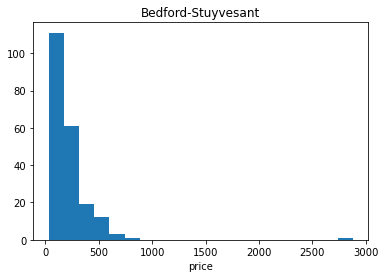

In [20]:
plt.hist(df2_s1.price, bins=20)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

#### Examine extremes of prices - Bed Stuy

In [21]:
top_out = np.log(df2_s1.price).max()
bot_out = np.log(df2_s1.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}');

Log of outlier for uncorrected prices: (3.4011973816621555, 7.965545573129992)


In [22]:
#prices greater than a dollar ($1)
df2_s1_corrected = df2_s1[df2_s1['price']>1]

top_out = np.log(df2_s1_corrected.price).max()
bot_out = np.log(df2_s1_corrected.price).min()
print(f'Log of outlier for corrected prices: {bot_out,top_out}');

Log of outlier for corrected prices: (3.4011973816621555, 7.965545573129992)


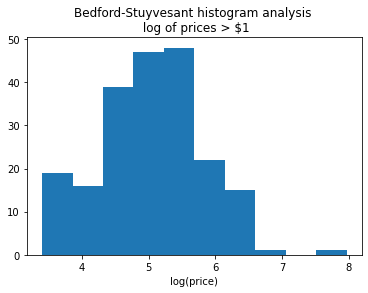

In [23]:
plt.hist(np.log(df2_s1_corrected.price))
plt.title('Bedford-Stuyvesant histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

In [24]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

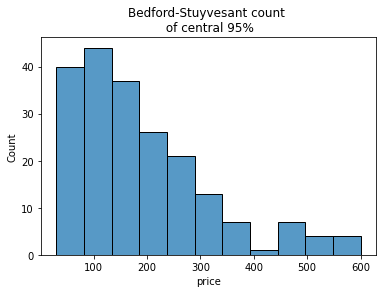

In [25]:
sb.histplot(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

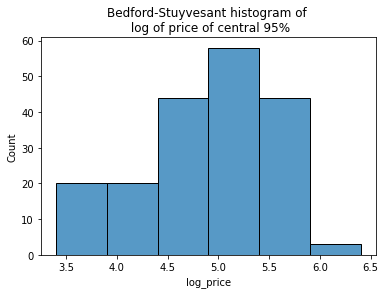

In [26]:
array = reject_outliers(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

In [27]:
bed_stuy_mean = np.mean(array)
bed_stuy_median = np.median(array)
bed_stuy_mode = st.mode(array)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_mean)}')
print(f'median: ${int(bed_stuy_median)}')
print(f'mode: ${bed_stuy_mode.mode[0]}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean: $159
median: $150
mode: $90
count: 189


In [28]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean of log of prices: 4.88
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 4.5
count: 189


### Bed-stuy "Entire Home/ Apt"

In [29]:
df2_bedstuy = df2.groupby('ZipCodes').get_group(11238)
df2_bedstuy;

In [30]:
df2_bedstuy_apt = df2_bedstuy.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_apt;

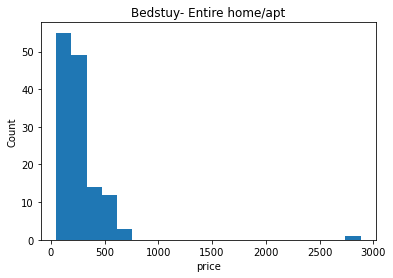

In [31]:
plt.hist(df2_bedstuy_apt.price, bins=20)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

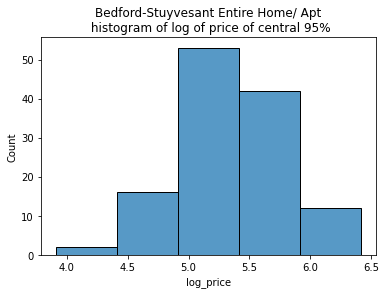

In [32]:
bedstuy_array = reject_outliers(df2_bedstuy_apt[ df2_bedstuy_apt['price']>0 ]['price'])
array = reject_outliers(bedstuy_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [33]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}\n')

print(f'log(median): {round(np.log(np.median(array)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.34
median of log of prices: 5.3 ≠ log(median)
mode of log of prices: 5.16
count: 125

log(median): 5.3


#### Williamsburg

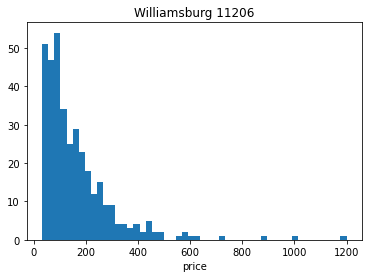

In [34]:
plt.hist(df2_s2.price, bins=20)
plt.title('Williamsburg 11206')
plt.xlabel("price");

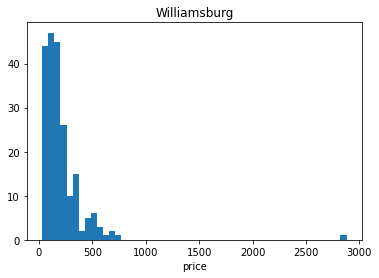

In [35]:
plt.hist(df2_s1.price, bins=20)
plt.title('Williamsburg')
plt.xlabel('price');

#### Examine extreme of prices - Williamsburg

Log of outlier for uncorrected prices: (3.4965075614664802, 7.090076835776092)
Log of outlier for corrected prices: (3.5, 7.09)


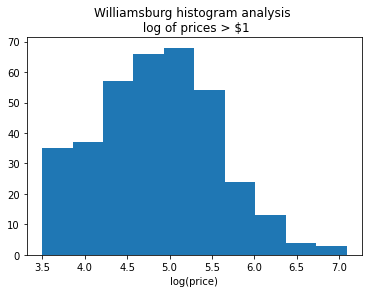

In [37]:
top_out = np.log(df2_s2.price).max()
bot_out = np.log(df2_s2.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}')

#prices greater than a dollar ($1)
df2_s2_corrected = df2_s2[df2_s2['price']>1]
top_out = np.log(df2_s2_corrected.price).max()
bot_out = np.log(df2_s2_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s2_corrected.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

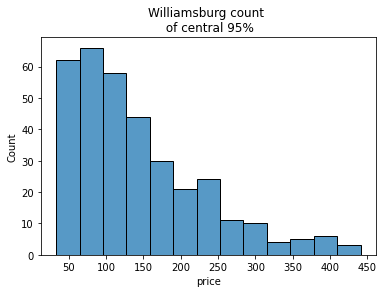

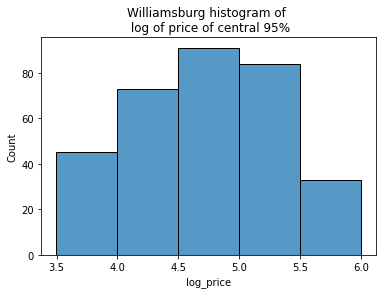

In [38]:
sb.histplot(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [39]:
williamsburg_mean = np.mean(array)
williamsburg_median = np.median(array)
williamsburg_mode = st.mode(array)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_mean,2)}')
print(f'median of natural log of prices: {round(williamsburg_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg

mean: $128
median: $109
mode: $38


mean of natural log of prices: 4.7
median of natural log of prices: 4.7 ≠ ln(median)
mode of natural log of prices: 3.64
count: 326


### Williamsburg "Entire Home/ Apt"

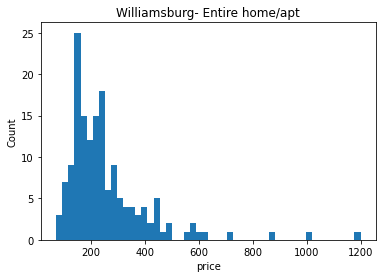

In [40]:
df2_williamsburg = df2.groupby('ZipCodes').get_group(11206)
df2_williamsburg_apt = df2_williamsburg.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_apt.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

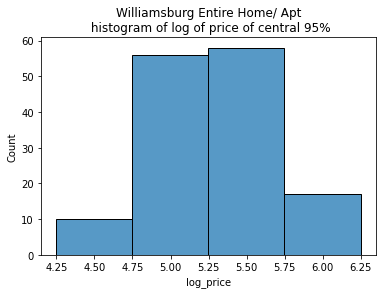

In [41]:
williamsburg_array = reject_outliers(df2_williamsburg_apt[ df2_williamsburg_apt['price']>0 ]['price'])
array = reject_outliers(williamsburg_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [42]:
log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_mean,2)}')
print(f'median of log of prices: {round(williamsburg_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Harlem

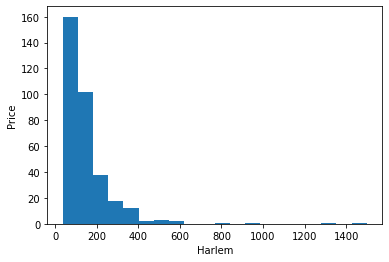

In [43]:
plt.hist(df2_s3.price,bins = 20)
plt.xlabel('Harlem')
plt.ylabel("Price");

#### Examine extreme of prices - Harlem

Log of outlier for uncorrected prices: (3.56, 7.31)
Log of outlier for corrected prices: (3.56, 7.31)


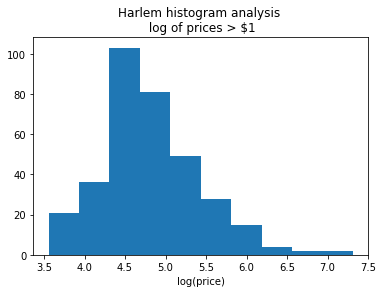

In [44]:
top_out = np.log(df2_s3.price).max()
bot_out = np.log(df2_s3.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_out,2),round(top_out,2)}')

#prices greater than a dollar ($1)
df2_s3_corrected = df2_s3[df2_s3['price']>1]
top_out = np.log(df2_s3_corrected.price).max()
bot_out = np.log(df2_s3_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s3_corrected.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

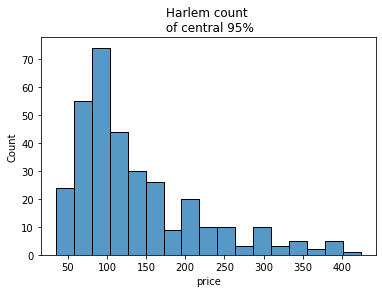

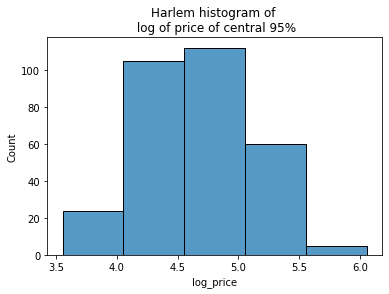

In [45]:
sb.histplot(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [46]:
harlem_mean = np.mean(array)
harlem_median = np.median(array)
harlem_mode = st.mode(array)

print('Harlem\n')
print(f'mean: ${int(harlem_mean)}')
print(f'median: ${int(harlem_median)}')
print(f'mode: ${harlem_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(harlem_mean,2)}')
print(f'median of natural log of prices: {round(harlem_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem

mean: $119
median: $102
mode: $100


mean of natural log of prices: 4.69
median of natural log of prices: 4.63 ≠ ln(median)
mode of natural log of prices: 4.61
count: 306


### Harlem "Entire Home/ Apt"

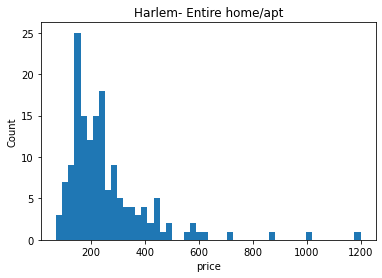

In [47]:
df2_harlem = df2.groupby('ZipCodes').get_group(11206)
df2_harlem_apt = df2_harlem.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_apt.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

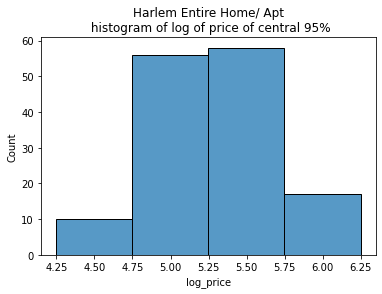

In [48]:
harlem_array = reject_outliers(df2_harlem_apt[ df2_harlem_apt['price']>0 ]['price'])
array = reject_outliers(harlem_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [49]:
log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_mean,2)}')
print(f'median of log of prices: {round(harlem_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.31
median of log of prices: 5.32 ≠ log(median)
mode of log of prices: 5.01
count: 141


#### Interpretation

The aim was to get a normally distributed curve for our assumptions in obtaining a mean price per night. Without correcting for outliers, the data seems to approach a logarithmic or skewed normally distributed curve, in which case taking the median or mode for the optimum price would be most appropriate. We choose the mode, since this measure is more stable as it directly depends on the y-axis of the histogram where as the mean and median directly depends on the x-axis.

### Proportion of AirBNB Listings by Borough and Room Type in NYC

The 1st pie chart shows 95% of the AirBnB listings are in Manhattan, Brooklyn and Queens. Brooklyn and Staten Island make up the remaining listings. Manhattan and Brooklyn alone make up neary 80% of the listings.

The 2nd pie chart shows the listings distributed by room type. Most of the observations consist of entire home / apartments, or private rooms. Hotel and shared rooms are an insignificant proportion of the distribution.

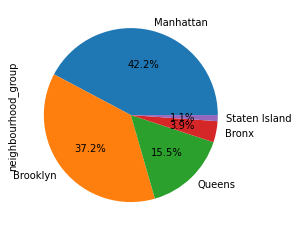

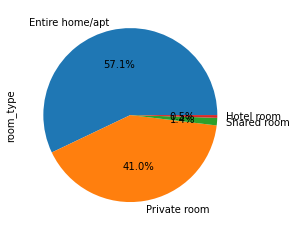

In [50]:
#Create a pie chart showing the percentage of listings per bourrough.
df1 = df.neighbourhood_group.value_counts()
df1.plot.pie(autopct="%.1f%%")
plt.show()

df2 = df.room_type.value_counts()
df2.plot.pie(autopct="%.1f%%")
plt.show()

### NYC AirBNB Listing Price Statistics by Borough

The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by neighborhood group or burrough in New York City. There is wide variability in the observations, with standard deviations consistently higher than the mean for each burrough. Mean prices are consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Average prices are highest in Manhattan, Brooklyn, and Queens respectively.

neighbourhood_group       price                         \
                                  count        mean median         std min   
neighbourhood_group                                                          
Bronx                              1568  124.737245   90.0  278.572839   0   
Brooklyn                          14845  157.927114  115.0  209.526092   0   
Manhattan                         16847  264.933341  175.0  473.171623   0   
Queens                             6175  131.365506   94.0  213.120396   0   
Staten Island                       446  143.163677  103.5  194.997315  33   

                            
                       max  
neighbourhood_group         
Bronx                 9994  
Brooklyn             10000  
Manhattan            16500  
Queens               10000  
Staten Island         2500

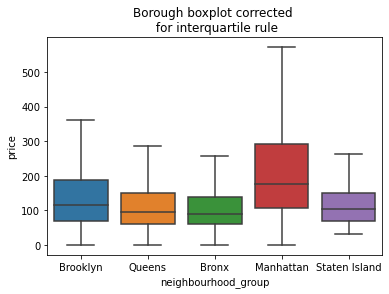

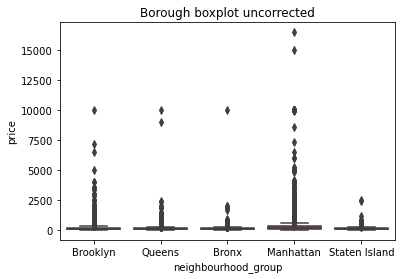

In [51]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('neighbourhood_group').aggregate({'neighbourhood_group':'count',
                                    'price':['mean','median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], 
            x = df['neighbourhood_group'], 
            showfliers = False)
plt.title('Borough boxplot corrected \n for interquartile rule')
plt.show()

sb.boxplot(y = df['price'], x = df['neighbourhood_group'], showfliers = True)
plt.title('Borough boxplot uncorrected')
plt.show()

### NYC AirBNB Listing Price Statistics by Room Type
The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by room type in New York City. As in the distribution by borough section, there is wide variuability with standard deviations consistently higher than the mean for each burrough (Hotel rooms being the exception). Mean prices are also consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Comparisons of the 1st boxplot (corrected for outliers) with the second (not corrected for outliers bear this out.

#### Major Room Type Categories
These categories encompass 98% of the listings and are likely to be more useful for informing business decisions.
- Entire home/apt: Entire residences make up 57% of the dataset and are the category with the second highest average price. Prices range from \\$10 to \\$15K which could be indicative of data errors and/ or outliers.
- Private room: Private rooms constitute 42% of the listings in the data and are the category with the third highest average price. Prices range from \\$10 to \\$16.5K which could be indicative of data errors and/ or outliers.

#### Minor Room Type Categories
Categories that are a significantly smaller number of the overall listings in the dataset. They are less likely to be useful for informing business decisions.
- Shared room: Shared rooms constitute 1.4% of the listings with the lowest average price of all room type categories. Prices range from \\$10 to \\$10K which seems to indicate data entry errors and/or outliers.
- Hotel room: Hotel rooms seem to have the highest average price and the least number of observations. This is the only category where the standard deviation is less than the mean, which suggest a more limited number of high priced outliers.


room_type       price                              
                    count        mean median         std min    max
room_type                                                          
Entire home/apt     22761  251.546022    180  338.044654  10  15000
Hotel room            202  371.648515    291  303.482491   0   1998
Private room        16361  122.936495     75  356.373737  10  16500
Shared room           557  119.398564     66  454.106078  10  10000

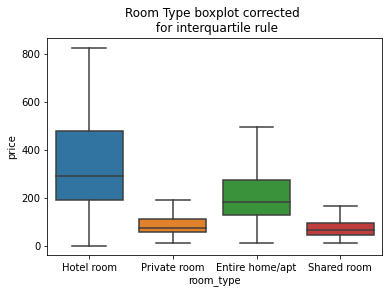

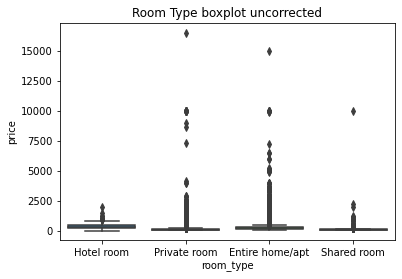

In [52]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('room_type').aggregate({'room_type':'count','price':['mean', 'median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = False)
plt.title('Room Type boxplot corrected \n for interquartile rule')
plt.show()
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = True,saturation=0.75)
plt.title('Room Type boxplot uncorrected')
plt.show()

### AirBNB Listings Statistics by Borough and Room Type in NYC
The listings dataset was aggregated by borough and room type for statistical analysis. The results underscore the need to remove outliers and illogical values from the data.

In [53]:
#Show price statistics by neighborhood group and room type
df_borrough = df[[ 'neighbourhood_group', 'room_type','price']]
display(df_borrough.groupby(['neighbourhood_group', 'room_type']).aggregate({'count',
    'mean', 'median','std', 'min', 'max'}))

price                            \
                                    median  count        mean    max   
neighbourhood_group room_type                                          
Bronx               Entire home/apt    130    736  164.569293   2000   
                    Hotel room           0      1    0.000000      0   
                    Private room        65    793   90.527112   9994   
                    Shared room         35     38   70.447368    775   
Brooklyn            Entire home/apt    169   8154  216.452539   7184   
                    Hotel room         145      9  177.555556    529   
                    Private room        69   6510   86.907680  10000   
                    Shared room         45    172   70.389535   1000   
Manhattan           Entire home/apt    205  10862  300.645829  15000   
                    Hotel room         307    183  392.163934   1998   
                    Private room       100   5552  194.915346  16500   
                    Shared room         82    250  175.124000  10000   
Queens              Entire home/apt    150   2736  191.693713  10000   
                    Hotel room         209      9  189.888889    282   
                    Private room        65   3334   83.118776   9000   
                    Shared room         50     96   82.093750   1250   
Staten Island       Entire home/apt    129    273  180.487179   2500   
                    Private room        68    172   84.412791    500   
                    Shared room         59      1   59.000000     59   

                                                     
                                            std min  
neighbourhood_group room_type                        
Bronx               Entire home/apt  156.115405  28  
                    Hotel room              NaN   0  
                    Private room     356.925302  11  
                    Shared room      124.059423  10  
Brooklyn            Entire home/apt  228.702022  30  
                    Hotel room       194.204860   0  
                    Private room     157.575675  10  
                    Shared room       84.576582  15  
Manhattan           Entire home/apt  420.865138  29  
                    Hotel room       308.268374   0  
                    Private room     549.384274  10  
                    Shared room      662.012440  29  
Queens              Entire home/apt  245.295887  10  
                    Hotel room        89.324471   0  
                    Private room     169.268863  19  
                    Shared room      156.164089  16  
Staten Island       Entire home/apt  236.437035  39  
                    Private room      65.521555  33  
                    Shared room             NaN  59

### Correlation Matrix
A correlation matrix was conducted for the listings data. At this point, most of the factors appear to be weakly correlated with price, which is the primary variable of concern.

In [54]:
df.corr(method='pearson')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
id,1.000000,0.335359,-0.004366,0.079277,0.047596,-0.119177,-0.185724,0.246370,0.040260,0.286508,-0.080899
host_id,0.335359,1.000000,0.027405,0.144694,0.039558,-0.147641,-0.095511,0.271079,-0.024191,0.247358,0.126596
latitude,-0.004366,0.027405,1.000000,0.048995,0.027974,0.030504,-0.033748,-0.037751,0.033737,-0.018182,-0.034825
longitude,0.079277,0.144694,0.048995,1.000000,-0.123122,-0.083799,0.041505,0.102208,-0.071354,0.123042,0.057616
price,0.047596,0.039558,0.027974,-0.123122,1.000000,-0.035304,-0.032691,0.019562,0.042761,0.095482,-0.002458
minimum_nights,-0.119177,-0.147641,0.030504,-0.083799,-0.035304,1.000000,-0.138135,-0.227912,0.117108,-0.061480,-0.201601
number_of_reviews,-0.185724,-0.095511,-0.033748,0.041505,-0.032691,-0.138135,1.000000,0.520748,-0.092435,0.085598,0.640901
reviews_per_month,0.246370,0.271079,-0.037751,0.102208,0.019562,-0.227912,0.520748,1.000000,-0.029656,0.209944,0.815119
calculated_host_listings_count,0.040260,-0.024191,0.033737,-0.071354,0.042761,0.117108,-0.092435,-0.029656,1.000000,0.125885,-0.051553
availability_365,0.286508,0.247358,-0.018182,0.123042,0.095482,-0.061480,0.085598,0.209944,0.125885,1.000000,0.144143


## Map Visualization of the Distribution of Price by Neighborhood in NYC

This section provides analysis on the distribution of price by neighborhood. The mean price by neighborhood was computed from the data, keyed on a geojson file and incorporated into a folium map. There are several clusters of relatively higher prices, but the most significant one is around the Manhattan area.

## Conclusion and TakeAways

- Average listing prices for Manhattan tend to be the highest, followed by Brooklyn, Queens, Staten Island, and the Bronx. Most of the listings are in Manhattan, Brooklyn, and Queens.

- Entire residences/apartments and private rooms comprise ~97% of the listings here. Hotels and shared rooms are less than 2% of the dataset. Hotels tend to have the highest average price followed by residences, private rooms, and lastly shared rooms. Any predictive model underlying algorithms should be differentiated by room type. In terms of business analytics utility, residences and private rooms seem to be the most promising, while hotels and shared rooms may be less useful due to the relatively limited amount of data.
- The variability in the data is significant. The data should be disaggregated by room type, and all values greater than the 3rd quartile + (1.5 * IQR) should be removed. also, all zero values should also be removed.
- It is hypothesized that properties closer to either Manhattan or other significant attractions will have higher list prices ceteris paribus.